In [1]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe
from openrtdynamics2.ORTDtoNumpy import ORTDtoNumpy

from vehicle_lib import *
import vehicle_lib.path_transformations as pt
from vehicle_lib.motion_primitives import *


In [2]:
Ts = 0.01

In [3]:
# load track data
with open("track_data/simple_track.json", "r") as read_file:
    track_data = json.load(read_file)


# Create a path transformer

In [4]:
path_transform = pt.LateralPathTransformer(wheelbase=3.0)

compiling system Sys1000_store_input_data (level 1)... 
compiling system Sys1003_optim_loop (level 3)... 
compiling system Sys1002_tracker (level 2)... 
compiling system Sys1004_controller (level 2)... 
compiling system Sys1005_simulation_model (level 2)... 
compiling system Sys1001_process_data (level 1)... 
compiling system simulation (level 0)... 


# Define profiles for the lateral distance to the original path

compiling system simulation (level 0)... 


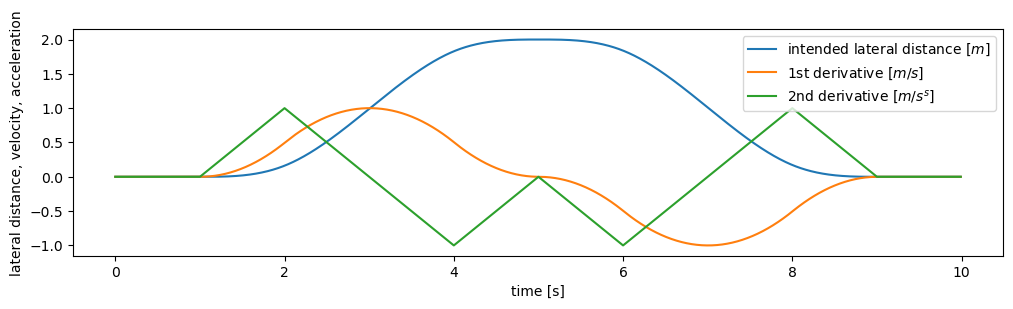

In [5]:
lateral_profile = generate_one_dimensional_motion(Ts, T_phase1=1, T_phase2=3, T_phase3=1, T_phase4=3, T_phase5=2)

plot_lateral_profile(lateral_profile)

# Perform the transformation

Perform a lateral shift given the profile for the lateral distance to the original path.

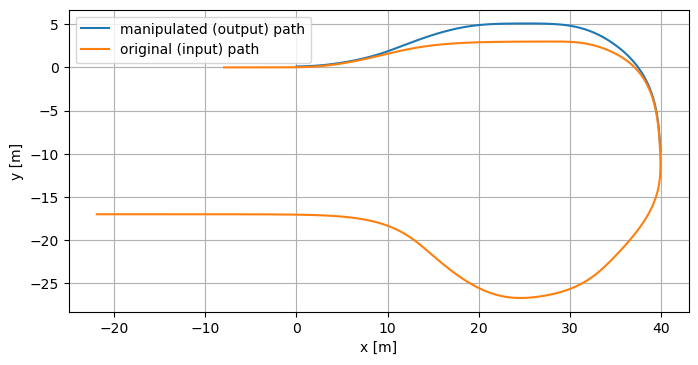

In [6]:
output_path = path_transform.run_lateral_path_transformer( track_data, lateral_profile )

plt.figure(figsize=(8,4), dpi=100)
plt.plot( output_path['X'], output_path['Y']+0.1 )
plt.plot( track_data['X'], track_data['Y'] )
plt.legend(['manipulated (output) path', 'original (input) path'])
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

The profiles for the curvature of the obtained path, and the steering angle and steering rate of a vehicle following the generatad path are given by:

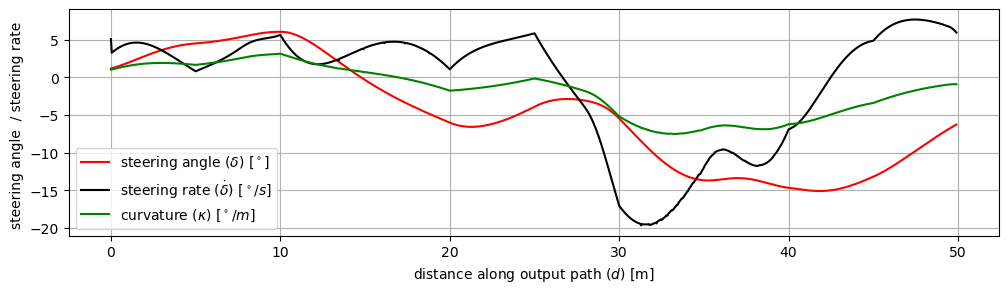

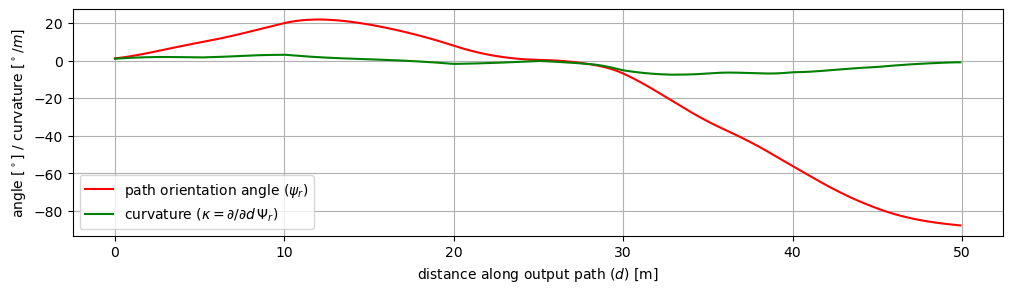

In [7]:
plot_path(output_path, show_xy=False)

# Parameter variation

Perform parameterized manipulations.
This might be an example on how to avoid an static obstacle using loop-based planning.

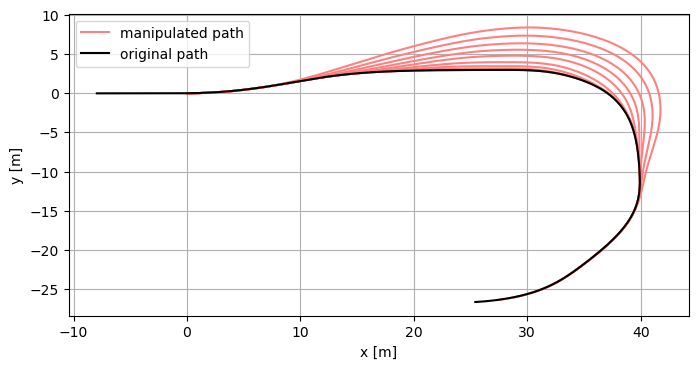

In [8]:
# compute multiple paths in a loop
output_paths = []

for duration_of_side_movement in np.linspace(0.3, 5, 10):

    lateral_profile = generate_one_dimensional_motion(
        Ts, 
        T_phase1=4 - 0.6*duration_of_side_movement, 
        T_phase2=duration_of_side_movement, 
        T_phase3=1, 
        T_phase4=duration_of_side_movement,
        T_phase5=4
    )
    output_paths.append( path_transform.run_lateral_path_transformer( track_data, lateral_profile ) )



# plot
plt.figure(figsize=(8,4), dpi=100)

for output_path in output_paths:
    pi, = plt.plot( output_path['X'], output_path['Y'], color=(1.0, 0.5, 0.5) )
    
pi.set_label('manipulated path')

Nmax = 1700 # maximal amount of original path to show
p1, = plt.plot( track_data['X'][0:Nmax], track_data['Y'][0:Nmax], 'k' )
p1.set_label('original path')
plt.legend()

plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

# Passing the input path samples on demand via a callback function

In [21]:
def path_generator(input_data, index):
    # callback to put path samples
    #
    # the one sample for multiple variables must be written into
    # the structure input_data. The parameter index is increased
    # after each call to this function.
    #
    if index >= len(track_data['D']):
        # indicated the end of the input path
        return True

    input_data.d_sample    = track_data['D'][index]
    input_data.x_sample    = track_data['X'][index]
    input_data.y_sample    = track_data['Y'][index]
    input_data.psi_sample  = track_data['PSI'][index]
    input_data.K_sample    = track_data['K'][index]

    return False


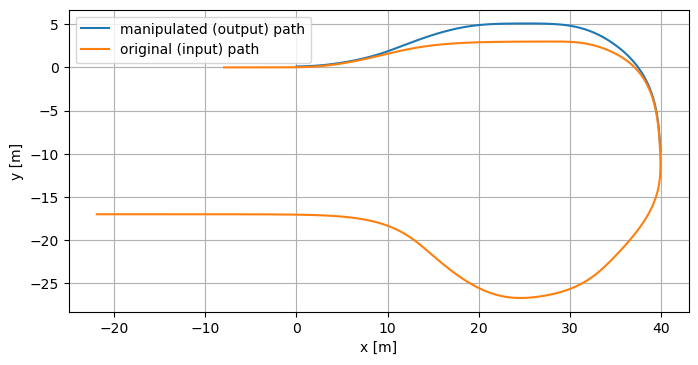

In [23]:
lateral_profile = generate_one_dimensional_motion(Ts, T_phase1=1, T_phase2=3, T_phase3=1, T_phase4=3, T_phase5=2)
output_path = path_transform.run_lateral_path_transformer( path_generator, lateral_profile )

plt.figure(figsize=(8,4), dpi=100)
plt.plot( output_path['X'], output_path['Y']+0.1 )
plt.plot( track_data['X'], track_data['Y'] )
plt.legend(['manipulated (output) path', 'original (input) path'])
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()